# Captcha Data Cleaning and EDA

### Imports

In [1]:
import os
import string
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline 

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Model

from PIL import Image
import cv2
tf.__version__, cv2.__version__

('2.1.0', '4.2.0')

## Data Cleaning

### Load Data

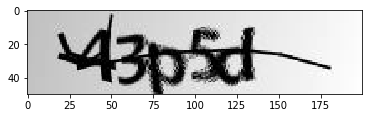

In [5]:
# example from 1000 image dataset
simg=cv2.imread('data/s_data/43p5d.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(simg, cmap=plt.get_cmap('gray'))

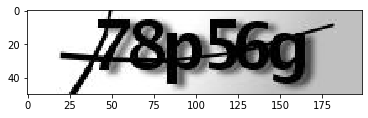

In [6]:
# example from AWS website
img=cv2.imread('trial.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

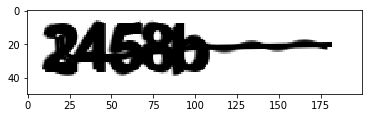

In [7]:
# example from 100,000 image dataset 
img=cv2.imread('data/l_data/2458b.png', cv2.IMREAD_UNCHANGED)[:,:,3]

# remove border 
img[[0,49],1:199] -= 255
img[:,0] -= 255
img[:,199] -= 255

plt.imshow(img, cmap=plt.cm.binary)

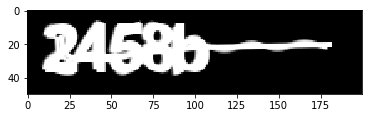

In [8]:
# for anti grayscale
img=cv2.imread('data/l_data/2458b.png',cv2.IMREAD_UNCHANGED)
a = img[:,:,3]
lst = []

for i in a.flatten():
    lst.append(np.abs(i - 255))
lst = np.array(lst)
img = lst.reshape(50, 200)

img[[0,49],1:199] += 255
img[:,0] += 255
img[:,199] += 255

plt.imshow(img, cmap=plt.cm.binary)

### Removing Border and Create Target

In [9]:
# check data folders for non image files
def s_data_check(from_src=False):
    '''Check for non PNG files
    '''
    if from_src:
        path = '../data/s_data/'
    else:
        path = 'data/s_data/'
        
    for name in os.listdir(path):
        if name[-4:] == '.png' or name[-4:] == '.jpg':
            pass
        else:
            print(name)
        
def l_data_check(from_src=False):
    '''Check for non PNG files
    '''
    if from_src:
        path = '../data/l_data/'
    else:
        path = 'data/l_data/'
        
    for name in os.listdir(path):
        if name[-4:] == '.png':
            pass
        else:
            print(name)

In [10]:
s_data_check() # should not print anything

In [11]:
l_data_check() # should not print anything

In [12]:
len(os.listdir('data/l_data'))

109053

In [13]:
chars = string.ascii_lowercase + "0123456789"
num_chars = len(chars)

In [14]:
# image data processing functions

def remove_img_border(img):
    # remove border
    img[[0,49],1:199] -= 255
    img[:,0] -= 255
    img[:,199] -= 255
    
    return img
    
def l_data_process(from_src=False):
    '''Processes the l_data folder of 109,053 images 
    Parameters:
    -----------
    from_src: True if function is run from src folder
    
    Returns:
    X: 4 tensor numpy array of image data
    y: One hot encoded targets
    labels: labels for image data
    '''
    if from_src:
        path = '../data/l_data/'
    else:
        path = 'data/l_data/'
        
    X = np.zeros((len(os.listdir(path)), 50, 200, 1)) 
    y = np.zeros((5, len(os.listdir(path)), num_chars)) 
    labels = []
    
    for i, name in enumerate(os.listdir(path)):
        img_path = path + name
        img = cv2.imread(img_path , cv2.IMREAD_UNCHANGED)[:,:,3]
        
        img = remove_img_border(img)
        img = img / 255.0
        img = img.reshape(50, 200, 1)
        
        # Define labels using OneHotEncoding
        label = name[:-4]
        target = np.zeros((5, num_chars))
        for j, l in enumerate(label):
            ind = chars.find(l)
            target[j, ind] = 1
        
        X[i] = img
        y[:, i] = target
        labels.append(label)
   
    return X, y, labels

def s_data_process(from_src=False):
    '''Processes the s_data folder of 1070 images 
    Parameters:
    -----------
    from_src: True if function is run from src folder
    
    Returns:
    X: 4 tensor numpy array of image data
    y: One hot encoded targets
    labels: labels for image data
    '''
    if from_src:
        path = '../data/s_data/'
    else:
        path = 'data/s_data/'
        
    X = np.zeros((len(os.listdir(path)), 50, 200, 1)) 
    y = np.zeros((5, len(os.listdir(path)), num_chars))
    labels = []
    
    for i, name in enumerate(os.listdir(path)):
        img_path = path + name
        img = cv2.imread(img_path , cv2.IMREAD_GRAYSCALE)
        
        # remove background
        flatimg = pd.Series(img.flatten()) 
        flatimg = flatimg.apply(lambda x: 255 if x > 150 else x)
        flatimg = flatimg.apply(lambda x: np.abs(x - 255))
        img = flatimg.values.reshape(50,-1)

        img = img / 255.0
        img = img.reshape(50, 200, 1)
        
        # Define labels using OneHotEncoding
        label = name[:-4]
        target = np.zeros((5, num_chars))
        for j, l in enumerate(label):
            ind = chars.find(l)
            target[j, ind] = 1
        
        X[i] = img
        y[:, i] = target
        labels.append(label)
   
    return X, y, labels

In [15]:
def mix_img(img, fill_val = 0):
    # random rotate value
    ang_list = [-5,-4,-3,-2,-1,0,0,0,0,0,1,2,3,4,5]
    ang = random.choice(ang_list)
    # rotate image
    im = Image.fromarray(img)
    img = np.asarray(im.rotate(ang))
    
    # random shift value
    shif = np.random.randint(130,200,1)[0]
    # shift image
    img = img[:,:shif]
    size = (200 - shif) * 50
    stacker = np.repeat(fill_val, size).reshape(50,-1)
    img = np.hstack((stacker, img))
    
    return img

def l_data_mixer(from_src=False):
    if from_src:
        path = '../data/l_data/'
    else:
        path = 'data/l_data/'
        
    X = np.zeros((len(os.listdir(path)), 50, 200, 1)) 
    y = np.zeros((5, len(os.listdir(path)), num_chars)) 
    labels = []
    
    for i, name in enumerate(os.listdir(path)):
        img_path = path + name
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)[:,:,3]
        
        img = remove_img_border(img)
        
        # Mix up image data
        img = mix_img(img)
        
        img = img / 255.0
        img = img.reshape(50, 200, 1)
        
        # Define labels using OneHotEncoding
        label = name[:-4]
        target = np.zeros((5, num_chars))
        for j, l in enumerate(label):
            ind = chars.find(l)
            target[j, ind] = 1
        
        X[i] = img
        y[:, i] = target
        labels.append(label)
   
    return X, y, labels

def s_data_mixer(from_src=False):
    if from_src:
        path = '../data/s_data/'
    else:
        path = 'data/s_data/'
        
    X = np.zeros((len(os.listdir(path)), 50, 200, 1)) 
    y = np.zeros((5, len(os.listdir(path)), num_chars))
    labels = []
    
    for i, name in enumerate(os.listdir(path)):
        img_path = path + name
        img = cv2.imread(img_path , cv2.IMREAD_GRAYSCALE)
        
        # Mix up image data
        img = mix_img(img, fill_val=255)
        
        # remove background
        flatimg = pd.Series(img.flatten()) 
        flatimg = flatimg.apply(lambda x: 255 if x > 150 else x)
        flatimg = flatimg.apply(lambda x: np.abs(x - 255))
        img = flatimg.values.reshape(50,-1)

        img = img / 255.0
        img = img.reshape(50, 200, 1)
        
        # Define labels using OneHotEncoding
        label = name[:-4]
        target = np.zeros((5, num_chars))
        for j, l in enumerate(label):
            ind = chars.find(l)
            target[j, ind] = 1
        
        X[i] = img
        y[:, i] = target
        labels.append(label)
   
    return X, y, labels

In [16]:
#s_X, s_y, s_labels = s_data_process()
s_X, s_y, s_labels = s_data_mixer()
s_X.shape, s_y.shape

((1070, 50, 200, 1), (5, 1070, 36))

In [17]:
s_y[0].shape

(1070, 36)

In [18]:
X, y, llabels = l_data_mixer()
X.shape, y.shape

((109053, 50, 200, 1), (5, 109053, 36))

In [19]:
X[0].shape, y[:, 0].shape

((50, 200, 1), (5, 36))

In [20]:
# contours doesn't work with connected characters...

## Exploratory Data Analysis

In [56]:
slst_of_chars = []
for s in s_labels:
    slst_of_chars += [char for char in s]
len(slst_of_chars)/1070, len(slst_of_chars)

(5.0, 5350)

In [22]:
#pd.Series(slst_of_chars).value_counts().sort_index();

In [24]:
lst_of_chars = []
for s in llabels:
    lst_of_chars += [char for char in s]
len(lst_of_chars)/109053, len(lst_of_chars)

(5.0, 545265)

In [25]:
# Character Distribution for Large Image Dataset
pd.Series(lst_of_chars).value_counts().sort_index()

2    23887
3    23531
4    23721
5    23803
6    23883
7    23759
8    23426
a    23804
b    23535
c    23722
d    23442
e    23879
f    23731
g    23629
h    23647
k    23629
m    23592
n    24148
p    23580
r    23846
w    23575
x    23817
y    23679
dtype: int64

In [57]:
def remove_grid_lines(axs):
    """Remove the default grid lines from a collection of axies."""
    for ax in axs.flatten():
        ax.grid(False)

In [34]:
def apply_convolution_to_image(image,
                               image_shape=(50, 200),
                               filter_shape = (5, 5)):
    """Apply a convolutional filter to an image.  The inputs here should be
    numpy arrays, this function will take care of converting them to tensors
    and back.
    """

    image_tensor = image.reshape(1, image_shape[0], image_shape[1], 1)
    #filter_tensor = convolutional_filter.reshape(filter_shape[0], filter_shape[1], 1, 1)
    
    
    imgm = layers.Input(shape=image_shape) # Get image as an input and process it through some Convs
    cn = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu')(imgm)
    #x = layers.MaxPooling2D(padding='same')(x)
    
    image_convloved = cn[0, :, :, 0]
    return image_convloved

In [35]:
def apply_max_pool_to_image(image, 
                            image_shape=(50,200), 
                            filter_shape = (2, 2)):
    image_tensor = image.reshape(1, image_shape[0], image_shape[1], 1)
    image_pooled_tensor = tf.nn.max_pool(
        image_tensor, 
        ksize=[1, 2, 2, 1], 
        strides=[1, 2, 2, 1], padding='SAME')
    image_pooled = image_pooled_tensor[0, :, :, 0]
    return image_pooled

In [40]:
# example from 100,000 image dataset 
img=cv2.imread('data/l_data/y223e.png', cv2.IMREAD_UNCHANGED)[:,:,3]

# remove border 
img = remove_img_border(img)
img = img / 255.0

#blurred = apply_convolution_to_image(img)
pooled = apply_max_pool_to_image(img)

In [38]:
def plot_convolution(before, after, axs):
    """Plot a 1 by 3 grid of images:
        - A before image.
        - A filter to apply.
        - The result of convolving the filter with the image.
    """
    axs[0].imshow(before, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[0].set_title("Before")
    axs[1].imshow(after, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[1].set_title("After")

In [41]:
#blurred.shape, 
pooled.shape

TensorShape([25, 100])

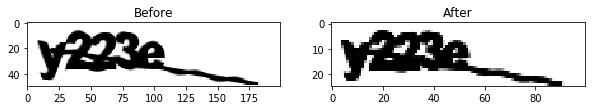

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(10, 8))

plot_convolution(img, pooled, axs)
remove_grid_lines(axs)

# after Max Pooling

## Split Data

#### Small Image Dataset

In [23]:
s_X.shape, s_y.shape

((1070, 50, 200, 1), (5, 1070, 36))

In [24]:
sX_train, sy_train = s_X[:900], s_y[:, :900]
sX_test, sy_test = s_X[900:], s_y[:, 900:]

In [25]:
sX_train.shape, sX_test.shape

((900, 50, 200, 1), (170, 50, 200, 1))

#### Large Image Dataset

In [26]:
X.shape, y.shape

((109053, 50, 200, 1), (5, 109053, 36))

In [27]:
X_train, y_train, ll_train = X[:77777], y[:, :77777], llabels[:77777]
X_test, y_test, ll_test = X[77777:93333], y[:, 77777:93333], llabels[77777:93333]
Xer, yer, ller = X[93333:], y[:, 93333:], llabels[93333:]

In [28]:
X_train.shape, X_test.shape, Xer.shape

((77777, 50, 200, 1), (15556, 50, 200, 1), (15720, 50, 200, 1))

### Merge Data

In [126]:
eX_train = np.vstack((Xer,sX_train))

In [127]:
ey_train = np.hstack((yer,sy_train))

In [128]:
eX_test = np.vstack((X_test,sX_test))
ey_test = np.hstack((y_test,sy_test))

In [129]:
eX_train.shape, eX_test.shape, ey_train.shape, ey_test.shape

((16620, 50, 200, 1), (15726, 50, 200, 1), (5, 16620, 36), (5, 15726, 36))

## Model Testing

### Build Model

In [29]:
# Model Outline

input_shape = (50, 200, 1)

# Input layer
imgm = Input(shape=input_shape)

# Convolution and Max Pooling layers
cn1 = Conv2D(32, (7, 7), padding='same', activation='relu')(imgm)
mp1 = MaxPooling2D(padding='same')(cn1)  

cn2 = Conv2D(64, (7, 7), padding='same', activation='relu')(mp1)
mp2 = MaxPooling2D(padding='same')(cn2)  

cn3 = Conv2D(32, (7, 7), padding='same', activation='relu')(mp2)
mp3 = MaxPooling2D(padding='same')(cn3)   
 
cn4 = Conv2D(16, (7, 7), padding='same', activation='relu')(mp3)
mp4 = MaxPooling2D(padding='same')(cn4)  

# Flatten and Dense layers
flat = Flatten()(mp4)
output = []
for _ in range(5):
    dens1 = Dense(64, activation='relu')(flat)
    drop = Dropout(0.5)(dens1)
    result = Dense(num_chars, activation='sigmoid')(drop)

    output.append(result)

In [30]:
# Compile model
model = Model(imgm, output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [31]:
model.summary();

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 200, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 200, 32)  1600        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 25, 100, 32)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 25, 100, 64)  100416      max_pooling2d[0][0]              
______________________________________________________________________________________________

In [32]:
X_train.shape

(77777, 50, 200, 1)

In [33]:
history = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]],
                 batch_size=64, epochs=10, verbose=2, validation_split=0.2)

Train on 62221 samples, validate on 15556 samples
Epoch 1/10
62221/62221 - 63s - loss: 14.7703 - dense_1_loss: 3.1630 - dense_3_loss: 3.1326 - dense_5_loss: 3.0466 - dense_7_loss: 2.9897 - dense_9_loss: 2.4360 - dense_1_accuracy: 0.0436 - dense_3_accuracy: 0.0527 - dense_5_accuracy: 0.0650 - dense_7_accuracy: 0.0688 - dense_9_accuracy: 0.1728 - val_loss: 11.2989 - val_dense_1_loss: 3.0854 - val_dense_3_loss: 2.7703 - val_dense_5_loss: 2.5397 - val_dense_7_loss: 2.2453 - val_dense_9_loss: 0.6542 - val_dense_1_accuracy: 0.0463 - val_dense_3_accuracy: 0.1129 - val_dense_5_accuracy: 0.1221 - val_dense_7_accuracy: 0.1340 - val_dense_9_accuracy: 0.7269
Epoch 2/10
62221/62221 - 58s - loss: 9.9462 - dense_1_loss: 3.0199 - dense_3_loss: 2.2080 - dense_5_loss: 2.2456 - dense_7_loss: 2.1296 - dense_9_loss: 0.3419 - dense_1_accuracy: 0.0471 - dense_3_accuracy: 0.1829 - dense_5_accuracy: 0.1557 - dense_7_accuracy: 0.1545 - dense_9_accuracy: 0.8722 - val_loss: 8.0104 - val_dense_1_loss: 2.8493 - val

In [99]:
eval1 = model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)

15556/15556 [==============================] - 5s 339us/sample - loss: 69.5757 - dense_1_loss: 13.4136 - dense_3_loss: 14.2126 - dense_5_loss: 14.2071 - dense_7_loss: 14.1062 - dense_9_loss: 13.6388 - dense_1_accuracy: 0.0507 - dense_3_accuracy: 0.0502 - dense_5_accuracy: 0.0440 - dense_7_accuracy: 0.0488 - dense_9_accuracy: 0.0682


In [100]:
eval2 = model.evaluate(Xer,[yer[0], yer[1], yer[2], yer[3], yer[4]], verbose=1)

15720/15720 [==============================] - 5s 346us/sample - loss: 69.6741 - dense_1_loss: 13.4121 - dense_3_loss: 14.3333 - dense_5_loss: 14.1881 - dense_7_loss: 14.0783 - dense_9_loss: 13.6652 - dense_1_accuracy: 0.0468 - dense_3_accuracy: 0.0469 - dense_5_accuracy: 0.0439 - dense_7_accuracy: 0.0487 - dense_9_accuracy: 0.0681


In [101]:
# average loss for each output in the two tests
out_loss = [i.round(3) for i in np.mean(np.array([eval1[:5], eval2[:5]]), axis=0)]; out_loss

[69.625, 13.413, 14.273, 14.198, 14.092]

In [102]:
# average accuracy for each output in the two tests
out_acc = [i.round(3) for i in np.mean(np.array([eval1[6:], eval2[6:]]), axis=0)]; out_acc

[0.049, 0.049, 0.044, 0.049, 0.068]

In [38]:
def predict_lots(X_test, y_test, labels):
    count = len(X_test)
    correct = 0
    all_preds = np.array(model.predict(X_test))
    
    for i in range(count):
        true = labels[i]

        onehotpred = all_preds[:,i,:]    
        pred = ''

        for i in onehotpred:
            c = chars[np.argmax(i)]
            pred += c

        if true == pred:
            correct += 1
            
        #print(true, pred)
            
    return (correct / count)

In [97]:
a_acc = predict_lots(X_test, y_test, ll_test)
print(round(a_acc, 3))

0.0


In [98]:
b_acc = predict_lots(Xer, yer, ller)
print(round(b_acc, 3))

0.0


#### Model Tuning with Mixed Data

4 CN, MP 16(5)/32(5)/32(5)/16(5) filters, batchsize=64, epochs=10
- [0.985, 0.931, 0.82, 0.962, 0.996], 0.728, 0.726


#### Model Tuning with Boring, Unmixed Data
- (0.956, 0.958), 0.850 = 1 CN, MP 16 filters
- (0.958, 0.958), 0.851 = 1 CN, MP 32 filters
- (0.976, 0.973), 0.904 = 2 CN, MP 16/32 filters
- (0.986, 0.986), 0.9447 = 3 CN, MP 16/32/32 filters, batchsize=64, epochs=10
- (0.985, 0.986), 0.9445 = 3 CN, MP 16/64/32 filters, batchsize=64, epochs=10
- (0.9966, 0.997), 0.987 = 3 CN, MP 16/64/32 filters, batchsize=64, epochs=50
- (0.983, 0.983), 0.929 = 4 CN, MP 16/32/16/16 filters, batchsize=64, epochs=10
- (0.992, 0.993), 0.971 = 4 CN, MP 16/32/32/16 filters, batchsize=64, epochs=10

- (0.995, 0.996), 0.981 = 4 CN, MP 16/32(5)/32/16 filters, batchsize=64, epochs=10
- (0.997, 0.997), 0.988 = 4 CN, MP 16/32(5)/32(5)/16 filters, batchsize=64, epochs=10
- (0.998, 0.998), 0.992 = 4 CN, MP 16/32(5)/32(5)/16(5) filters, batchsize=64, epochs=10
- **(0.998, 0.999), 0.995 = 4 CN, MP 16(5)/32(5)/32(5)/16(5) filters, batchsize=64, epochs=10**
- **(0.999, 0.999), 0.998 = 4 CN, MP 16(5)/32(5)/32(5)/16(5) filters, batchsize=64, epochs=50**
- (0.998, 0.999), 0.995 = 4 CN, MP 16(5)/32(5)/32(5)/16(5) filters, batchsize=256, epochs=10
- (0.998, 0.998), 0.992 = 4 CN, MP 16(5)/32(6)/32(5)/16(5) filters, batchsize=64, epochs=10


In [96]:
print(predict_lots(s_X, s_y, s_labels))

0.6728971962616822


In [58]:
def predict_one_path(img_path):
    img = cv2.imread(img_path , cv2.IMREAD_UNCHANGED)[:,:,3]
        
    # remove border
    img = remove_img_border(img)
    
    # mix image
    img = mix_img(img)
    
    img = img / 255.0
    img = img.reshape(1, 50, 200, 1)
    
    true = img_path[-9:-4]
    
    onehotpred = np.array(model.predict(img)).reshape(5,36)    
    pred = ''
    
    for i in onehotpred:
        c = chars[np.argmax(i)]
        pred += c

    return true, pred

def predict_one_spath(img_path):
    img = cv2.imread(img_path , cv2.IMREAD_GRAYSCALE)
        
    # remove background
    flatimg = pd.Series(img.flatten()) 
    flatimg = flatimg.apply(lambda x: 255 if x > 150 else x)
    flatimg = flatimg.apply(lambda x: np.abs(x - 255))
    img = flatimg.values.reshape(50,-1)

    img = img / 255.0
    img = img.reshape(1, 50, 200, 1)
        
    onehotpred = np.array(model.predict(img)).reshape(5,36)    
    pred = ''
    
    for i in onehotpred:
        c = chars[np.argmax(i)]
        pred += c

    return true, pred

def predict_one(img, true):
    
    onehotpred = np.array(model.predict(img.reshape(1,50,200,1))).reshape(5,36)    
    pred = ''
    
    for i in onehotpred:
        c = chars[np.argmax(i)]
        pred += c

    return true, pred

In [59]:
img_path = 'data/s_data/2cegf.png'
print(predict_one_spath(img_path))

('8p56g', 'x2nfy')


### Look at Layer Weights

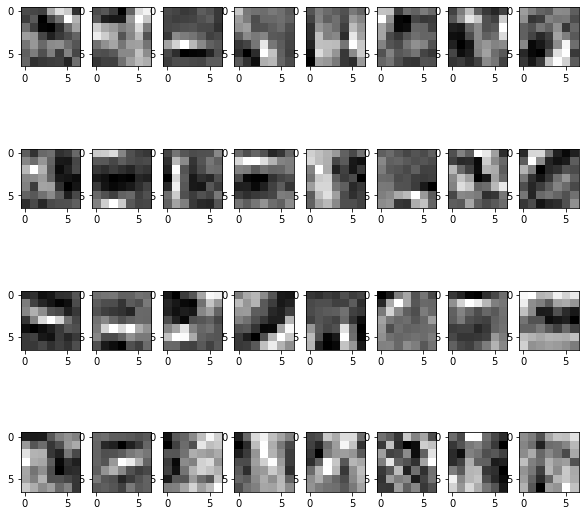

In [60]:
weights1_np = model.get_weights()[0] # 5 5 1 16

fig, axs = plt.subplots(4, 8, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):
    filter = weights1_np[:, :, 0, i]
    ax.imshow(filter, cmap=plt.cm.gray_r, interpolation="nearest")
remove_grid_lines(axs)

In [ ]:
img = cv2.imread('data/l_data/f25w8.png', cv2.IMREAD_UNCHANGED)[:,:,3]

# remove border 
img[[0,49],1:199] -= 255
img[:,0] -= 255
img[:,199] -= 255

zero_tensor = tf.constant(img.reshape(1, 50, 200, 1))
zero_activations = tf.nn.conv2d(zero_tensor, weights1_np[:,:,:,:32], strides=[1, 1, 1, 1], padding='SAME')
# or keras.activations.relu(zero_activations)
zero_activations_relu = np.maximum(zero_activations,0) 
# plot
fig, axs = plt.subplots(4, 8, figsize=(5, 8))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(zero_activations_relu[0, :, :, i],
              cmap=plt.cm.gray_r, interpolation="nearest")
remove_grid_lines(axs)
plt.tight_layout()

## Amazon Captcha Trial

In [66]:
img_path = 'trial.png'
img = cv2.imread(img_path , cv2.IMREAD_UNCHANGED)[:,:,0] #cv2.IMREAD_GRAYSCALE)   

flatimg = pd.Series(img.flatten()) 
flatimg = flatimg.apply(lambda x: 255 if x > 50 else x)
flatimg = flatimg.apply(lambda x: np.abs(x - 255))
flatimg = flatimg.values.reshape(50,-1)

In [67]:
flatimg.shape

(50, 199)

In [68]:
flatimg = np.hstack((flatimg, np.repeat(0,50).reshape(50,1)))

In [69]:
#pd.Series(flatimg.flatten()).value_counts()

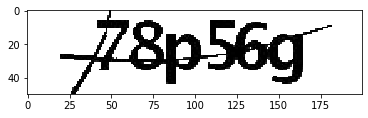

In [70]:
plt.imshow(flatimg, cmap=plt.cm.binary)

In [71]:
img = flatimg.copy()
img[:, :61] = 0
img = img[:, 50:]

In [72]:
img = np.hstack((img, np.repeat(0,2500).reshape(50,-1)))

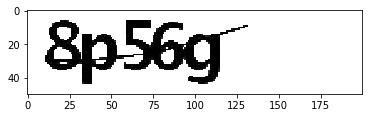

In [73]:
plt.imshow(img, cmap=plt.cm.binary)

In [75]:
true = '8p56g'
predict_one(img, true)

('8p56g', 'aaaaa')

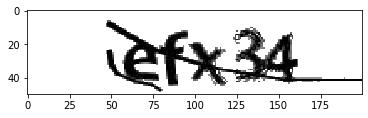

In [88]:
# example from 1000 image dataset
simg= s_X[0]
plt.imshow(simg.reshape(50,200), cmap=plt.cm.binary)

In [93]:
history2 = model.fit(sX_train, [sy_train[0], sy_train[1], sy_train[2], sy_train[3], sy_train[4]],
                 batch_size=64, epochs=10, verbose=2, validation_split=0.2)

Train on 720 samples, validate on 180 samples
Epoch 1/10
720/720 - 1s - loss: 0.3214 - dense_1_loss: 0.0705 - dense_3_loss: 0.0588 - dense_5_loss: 0.0891 - dense_7_loss: 0.0573 - dense_9_loss: 0.0398 - dense_1_accuracy: 0.9764 - dense_3_accuracy: 0.9778 - dense_5_accuracy: 0.9639 - dense_7_accuracy: 0.9764 - dense_9_accuracy: 0.9889 - val_loss: 44.6594 - val_dense_1_loss: 11.0179 - val_dense_3_loss: 9.3035 - val_dense_5_loss: 9.2843 - val_dense_7_loss: 9.1750 - val_dense_9_loss: 6.0510 - val_dense_1_accuracy: 0.0833 - val_dense_3_accuracy: 0.1444 - val_dense_5_accuracy: 0.1778 - val_dense_7_accuracy: 0.1722 - val_dense_9_accuracy: 0.3778
Epoch 2/10
720/720 - 1s - loss: 0.3207 - dense_1_loss: 0.0663 - dense_3_loss: 0.0603 - dense_5_loss: 0.0613 - dense_7_loss: 0.0716 - dense_9_loss: 0.0531 - dense_1_accuracy: 0.9819 - dense_3_accuracy: 0.9750 - dense_5_accuracy: 0.9750 - dense_7_accuracy: 0.9708 - dense_9_accuracy: 0.9764 - val_loss: 44.6753 - val_dense_1_loss: 11.1263 - val_dense_3_los

In [95]:
c_acc = predict_lots(sX_test, sy_test, s_labels[900:])
print(round(b_acc, 3))

0.969


## Pillow 

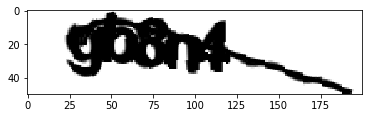

In [76]:
plt.imshow(X_train[0].reshape(50,200), cmap=plt.cm.binary)

In [77]:
X_train[0].shape

(50, 200, 1)

In [78]:
i = 0
predict_one(X_train[i], llabels[i])

('gb8n4', 'gb8n4')

In [79]:
X_train[i].shape

(50, 200, 1)

In [80]:
im = Image.open("data/l_data/f2am6.png")
im = im.rotate(0)

In [81]:
a = np.asarray(im)[:,:,3]
a 
#remove_img_border(a)

array([[255, 255, 255, ..., 255, 255, 255],
       [255,   0,   0, ...,   0,   0, 255],
       [255,   0,   0, ...,   0,   0, 255],
       ...,
       [255,   0,   0, ...,   0,   0, 255],
       [255,   0,   0, ...,   0,   0, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

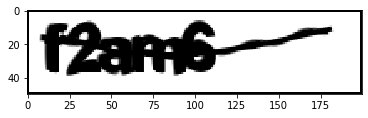

In [82]:
plt.imshow(a, cmap=plt.cm.binary)

In [83]:
im = Image.fromarray(a)

In [84]:
(left, upper, right, lower) = (2, 2, 198, 48)

# Here the image "im" is cropped and assigned to new variable im_crop
im_crop = im.crop((left, upper, right, lower))

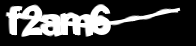

In [85]:
im_crop